In [11]:
import numpy as np
import pandas as pd
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import GridSearchCV

In [21]:
#Reading the file and splitting our target column
df = pd.read_csv (r'bank-additional-full.csv', sep = ';', engine= 'python')   

tussen = df[["y"]]
target = tussen.copy()
df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)

df=df[['age','default', 'contact', 'month', 'previous', 'poutcome', 'emp.var.rate', 'euribor3m', 'nr.employed']]

#Encoding all the catergorical variables and deleting them from the old dataframe
categories = ['contact','month','poutcome']
df_encoded = pd.get_dummies(df['default'], prefix='default', drop_first=True)
df_encoded.insert(0, 'ID', range(0, len(df_encoded)))
del df['default']

for x in categories:
    df_encoded_tussen = pd.get_dummies(df[x], prefix=x, drop_first=True)
    df_encoded_tussen.insert(0, 'ID', range(0, len(df_encoded_tussen)))
    df_encoded = pd.merge(df_encoded, df_encoded_tussen, on = 'ID', how = 'outer')
    del df[x]

df.insert(0, 'ID', range(0, len(df)))
features = pd.merge(df_encoded, df, on = 'ID', how = 'outer')
y = pd.get_dummies(target, drop_first=True)
del features['ID']

In [22]:
undersample = NearMiss(version=1, n_neighbors_ver3=3)
features, y = undersample.fit_resample(features, y)

In [23]:
# define lists to collect scores
train_scores, test_scores = list(), list()
def range_with_floats(start, stop, step):
    while stop > start:
        yield start
        start += step

In [27]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
ensemble = GradientBoostingClassifier(max_depth=1, n_estimators=1 ,random_state=23).fit(
        train_features, train_targets)

#After the first run we make jumps of 10 and lastly 1 for n_estimator

param_grid = {'learning_rate': [0.1, 0.01, pow(10,-3), pow(10,-4), pow(10,-5), pow(10,-6)]
              , 'n_estimators': range(1,6000,1000)}
grid = GridSearchCV(ensemble,param_grid,refit=True, verbose =2)
grid.fit(train_features,train_targets)
print(grid.best_estimator_)

grid_predictions = grid.predict(test_features)
print(confusion_matrix(test_targets,grid_predictions))
print(classification_report(test_targets,grid_predictions))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV] END ..................learning_rate=0.1, n_estimators=1; total time=   0.0s
[CV] END ..................learning_rate=0.1, n_estimators=1; total time=   0.0s
[CV] END ..................learning_rate=0.1, n_estimators=1; total time=   0.0s
[CV] END ..................learning_rate=0.1, n_estimators=1; total time=   0.0s
[CV] END ..................learning_rate=0.1, n_estimators=1; total time=   0.0s
[CV] END ...............learning_rate=0.1, n_estimators=1001; total time=   2.1s
[CV] END ...............learning_rate=0.1, n_estimators=1001; total time=   2.0s
[CV] END ...............learning_rate=0.1, n_estimators=1001; total time=   2.1s
[CV] END ...............learning_rate=0.1, n_estimators=1001; total time=   2.2s
[CV] END ...............learning_rate=0.1, n_estimators=1001; total time=   1.9s
[CV] END ...............learning_rate=0.1, n_estimators=2001; total time=  12.7s
[CV] END ...............learning_rate=0.1, n_es

[CV] END ............learning_rate=0.0001, n_estimators=2001; total time=   4.5s
[CV] END ............learning_rate=0.0001, n_estimators=2001; total time=   4.6s
[CV] END ............learning_rate=0.0001, n_estimators=2001; total time=   4.2s
[CV] END ............learning_rate=0.0001, n_estimators=2001; total time=   3.9s
[CV] END ............learning_rate=0.0001, n_estimators=3001; total time=   5.6s
[CV] END ............learning_rate=0.0001, n_estimators=3001; total time=   5.9s
[CV] END ............learning_rate=0.0001, n_estimators=3001; total time=   5.6s
[CV] END ............learning_rate=0.0001, n_estimators=3001; total time=   6.0s
[CV] END ............learning_rate=0.0001, n_estimators=3001; total time=   5.6s
[CV] END ............learning_rate=0.0001, n_estimators=4001; total time=   9.8s
[CV] END ............learning_rate=0.0001, n_estimators=4001; total time=   7.8s
[CV] END ............learning_rate=0.0001, n_estimators=4001; total time=   7.4s
[CV] END ............learnin

In [8]:
#Boosting the tree and predicting with ROC curve and classification reports
def gradient_boosted_tree(features, targets, learningRate, nEstimator):
    train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)
    ensemble = GradientBoostingClassifier(max_depth=1, learning_rate = learningRate, n_estimators= nEstimator ,random_state=23)
    
    k = 10
    kf = KFold(n_splits=k, shuffle = True)

    
    dt_scores = cross_val_score(ensemble, train_features, train_targets, scoring ='roc_auc' ,cv = kf)
    print("mean cross validation score: {}".format(np.round(np.mean(dt_scores),3)))

    ensemble.fit(train_features, train_targets)
    predictions = ensemble.predict(test_features)
    
    print("Confusion Matrix:")
    print(confusion_matrix(test_targets, predictions))

    print("Classification Report")
    print(classification_report(test_targets, predictions))
    
    #Beginning the plotting of ROC-curve
    pred_prob = ensemble.predict_proba(test_features)
    fpr, tpr, thresh = roc_curve(test_targets, pred_prob[:,1], pos_label=1)
    
    #Plot roc curves
    plt.plot(fpr, tpr, linestyle='--',color='orange', label='Boosted Trees')

    # title
    plt.title('ROC curve')
    # x label
    plt.xlabel('False Positive Rate')
    # y label
    plt.ylabel('True Positive rate')

    plt.legend(loc='best')
    plt.savefig('ROC',dpi=300)
    plt.show();
    
    #AUC Score
    auc_score = roc_auc_score(test_targets, pred_prob[:,1])
    print("AUC Score: " + str(np.round(auc_score , 3)))

mean cross validation score: 0.927
mean accuracy: 0.84
Confusion Matrix:
[[815 120]
 [153 768]]
Classification Report
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       935
           1       0.86      0.83      0.85       921

    accuracy                           0.85      1856
   macro avg       0.85      0.85      0.85      1856
weighted avg       0.85      0.85      0.85      1856



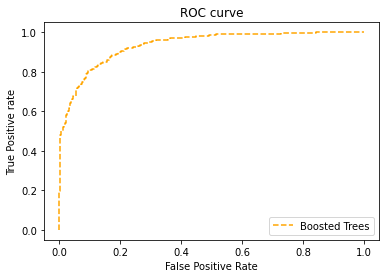

AUC Score: 0.936
Log-Loss: 5.08


In [91]:
gradient_boosted_tree(features, y.values.ravel(), learningRate, nEstimator)

1.0000000, train: 0.724, test: 0.741
101.0000000, train: 0.832, test: 0.842
201.0000000, train: 0.836, test: 0.846
301.0000000, train: 0.842, test: 0.851
401.0000000, train: 0.844, test: 0.854
501.0000000, train: 0.847, test: 0.853
601.0000000, train: 0.847, test: 0.853
701.0000000, train: 0.848, test: 0.853
801.0000000, train: 0.849, test: 0.854
901.0000000, train: 0.849, test: 0.853


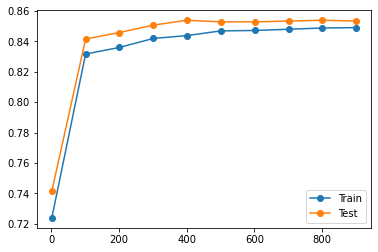

In [10]:
train_features, test_features, train_targets, test_targets = train_test_split(features, y.values.ravel(), test_size=0.2,
                                                                                  random_state=23)

#Now we set our n_estimator and learning_rate to the optimal value found in the last grid search
learningRate = 0
nEstimator = 0

#Check for overfitting

# define the tree depths to evaluate
values = [i for i in range_with_floats(1, 1000, 100)]
# evaluate a decision tree for each depth
for i in values:
    # configure the model
    model = GradientBoostingClassifier(max_depth=1, learning_rate = 0.23, n_estimators=i, random_state=23).fit(
        train_features, train_targets)
    # evaluate on the train dataset
    schatting = model.predict(train_features)
    train_acc = accuracy_score(train_targets, schatting)
    train_scores.append(train_acc)
    # evaluate on the test dataset
    test_schatting = model.predict(test_features)
    test_acc = accuracy_score(test_targets, test_schatting)
    test_scores.append(test_acc)
    # summarize progress
    print('%.7f, train: %.3f, test: %.3f' % (i, train_acc, test_acc))
# plot of train and test scores vs tree depth
pyplot.plot(values, train_scores, '-o', label='Train')
pyplot.plot(values, test_scores, '-o', label='Test')
pyplot.legend()
pyplot.show()
